In [1]:
### Import the required libraries
import numpy as np
import scipy
import matplotlib.pyplot as plt
import cmocean

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")

import tensorflow as tf
import tensorflow.keras as keras
from keras import metrics
import innvestigate

import os
from os.path import join
import sys

import xarray as xr
import xmitgcm
from xmitgcm import open_mdsdataset
import ecco_v4_py as ecco

import random

# See if GPUs are available
from keras import backend as K
if bool(K._get_available_gpus()):
    print("Running on GPU")
else:
    print("Running on CPU")

# Append to sys.path the absolute path to src/XAIRT
path_list = os.path.abspath('').split('/')
path_src_XAIRT = ''
for link in path_list[:-1]:
    path_src_XAIRT = path_src_XAIRT+link+'/'
sys.path.append(path_src_XAIRT+'/src')

# Now import module XAIRT
from XAIRT import *

### https://stackoverflow.com/questions/36288235/how-to-get-stable-results-with-tensorflow-setting-random-seed ###
### https://keras.io/examples/keras_recipes/reproducibility_recipes/ ###
SEED = 42
keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

tf.compat.v1.disable_eager_execution()

Running on GPU


2024-01-25 06:02:14.912000: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-25 06:02:35.508095: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-01-25 06:02:35.567676: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-01-25 06:02:35.570085: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/rep

In [2]:
### Sverdrup 
# mainDir  = '/scratch2/pillarh/eccov4r4'
# gridDir  = mainDir + '/GRID'
# thetaDir = mainDir + '/eccov4r4_nctiles_daily/THETA'

### Lonestar6
mainDir  = '/work/07665/shrey911/ls6/LRP_eccov4r4_data'
gridDir  = mainDir
thetaDir = mainDir

In [3]:
# %%capture --no-stderr --no-stdout --no-display 

# #### https://stackoverflow.com/questions/72821108/hdf5-warnings-when-accessing-xarray-dataset
# #### Necessary to suppress stderr output that crashes the file
# from dask.distributed import Client
# c = Client(threads_per_worker=1)

# #### Write thetaSurf data year-wise to netcdf file in scracth2
# #### I did it manually one year at a time in list `years` since stderr output crashes the file

# def subset(ds):
#     dict_subset = {'k':0}
#     ds_subset = ds.isel(dict_subset); # ; at the end to suppress output
#     return ds_subset; # ; at the end to suppress output

# years = np.arange(1992,2018)

# # for year in years:
# #     ds = xr.open_mfdataset(join(thetaDir,f'{year}/*/*.nc'), preprocess=subset); # ; at the end to suppress output
# #     ds.to_netcdf(f'/scratch2/shreyas/LRP_eccov4r4_data/thetaSurfECCOv4r4_{year}.nc', mode='w')

# for year in years:
#     print(year)
#     ds = xr.open_mfdataset(join(saltDir,f'{year}/*/*.nc'), preprocess=subset); # ; at the end to suppress output
#     ds.to_netcdf(f'/scratch2/shreyas/LRP_eccov4r4_data/saltSurfECCOv4r4_{year}.nc', mode='w')

In [4]:
### Sverdrup  - /scratch2/shreyas/LRP_eccov4r4_data
### Lonestar6 - /work/07665/shrey911/ls6/LRP_eccov4r4_data

ds = xr.open_dataset(f'/work/07665/shrey911/ls6/LRP_eccov4r4_data/thetaSurfECCOv4r4.nc')

In [5]:
hFacC = ecco.read_llc_to_tiles(gridDir, 'hFacC.data')
hFacC_mask = hFacC > 0
hFacC_mask = hFacC_mask.astype(float)

XC = ds['XC'].data
YC = ds['YC'].data

latMask = YC > -20.0
latMask = latMask.astype(float)

maskFinal = hFacC_mask * latMask
NaNmaskFinal = np.copy(maskFinal)
NaNmaskFinal[NaNmaskFinal == 0] = np.nan

da_hFacC_mask = xr.DataArray(
    data=hFacC_mask,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds['tile'].data,
        j    = ds['j'].data,
        i    = ds['i'].data,
    ),
    attrs=dict(description="hFacC mask 2D 1 if > 0, else 0"),
)

da_latMask = xr.DataArray(
    data=latMask,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds['tile'].data,
        j    = ds['j'].data,
        i    = ds['i'].data,
    ),
    attrs=dict(description="Latitude Mask 1 if > -20, else 0"),
)

da_maskFinal = xr.DataArray(
    data=maskFinal,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds['tile'].data,
        j    = ds['j'].data,
        i    = ds['i'].data,
    ),
    attrs=dict(description="Mask 2D 1 if > 0, else 0"),
)

da_NaNmaskFinal = xr.DataArray(
    data=NaNmaskFinal,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds['tile'].data,
        j    = ds['j'].data,
        i    = ds['i'].data,
    ),
    attrs=dict(description="Mask 2D True if > 0, else NaN"),
)

ds = ds.assign(hFacC_mask   = da_hFacC_mask,
          latMask      = da_latMask,
          maskFinal    = da_maskFinal,
          NaNmaskFinal = da_NaNmaskFinal)

wetpoints = np.nonzero(ds['maskFinal'].data)

load_binary_array: loading file /work/07665/shrey911/ls6/LRP_eccov4r4_data/hFacC.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4


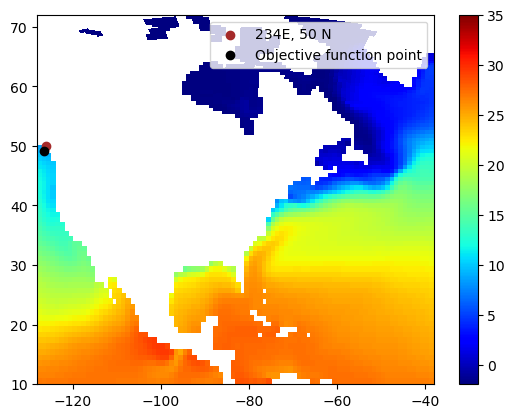

In [6]:
plt.pcolor(ds['XC'].isel(tile = 10), ds['YC'].isel(tile = 10), 
           ds['NaNmaskFinal'].isel(tile = 10)*ds['THETA'].isel(time = 0, tile = 10), 
           cmap = 'jet', vmax = 35)
plt.colorbar()
plt.scatter(-126.0, 50.0, color = 'brown', label = '234E, 50 N')
plt.scatter(ds['XC'].isel(tile = 10, j = 1, i = 43),
            ds['YC'].isel(tile = 10, j = 1, i = 43),
            color = 'black', label = 'Objective function point')
plt.legend()

Text(0.5, 1.0, 'MaskedTheta 1992_01_01')

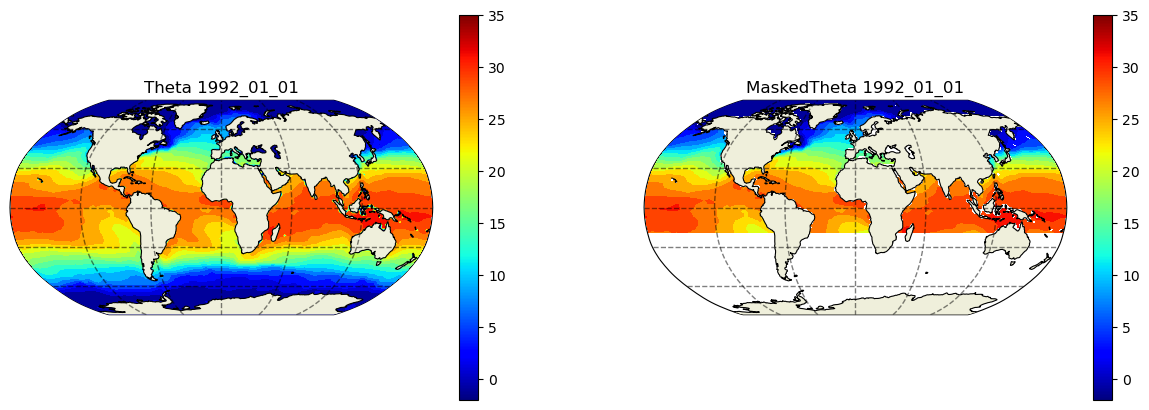

In [7]:
plt.figure(figsize=(15,5))

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'],
                              ds['THETA'].isel(time = 0),
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='jet', cmax = 35,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [1,2,1]);
P[1].set_title("Theta 1992_01_01")

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'],
                              ds['NaNmaskFinal']*ds['THETA'].isel(time = 0),
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='jet', cmax = 35,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [1,2,2]);
P[1].set_title("MaskedTheta 1992_01_01")

In [8]:
# X = ds['THETA'].data[731:,wetpoints[0],wetpoints[1],wetpoints[2]].copy()
# leap_yr_offsets_jan_feb   = [0,0,0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6]
# leap_yr_offsets_after_feb = [0,0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6]

X = ds['THETA'].data[:,wetpoints[0],wetpoints[1],wetpoints[2]].copy()
leap_yr_offsets_jan_feb   = [0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7]
leap_yr_offsets_after_feb = [1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7]

seasonal_trend = np.zeros((366, X.shape[1]))

#### Calculate seasonal trend

# Jan 1 - Feb 28
for d in range(59):
    for year in range(26):
        seasonal_trend[d] += X[d+365*year+leap_yr_offsets_jan_feb[year]]
seasonal_trend[:59] = seasonal_trend[:59] / 26.0

# Feb 29 starting 1996, so year 2 in 0-indexing
n = 0
for year in range(0,26,4):
    seasonal_trend[59] += X[365*year+n+59]
    n = n+1
seasonal_trend[59] = seasonal_trend[59] / 7.0
        
# Mar 1 - Dec 31
for d in range(60,366):
    for year in range(26):
        seasonal_trend[d] += X[d-1+365*year+leap_yr_offsets_after_feb[year]]
seasonal_trend[60:] = seasonal_trend[60:] / 26.0

#### Deseason data

# Jan 1 - Feb 28
for d in range(59):
    for year in range(26):
        X[d+365*year+leap_yr_offsets_jan_feb[year]] = X[d+365*year+leap_yr_offsets_jan_feb[year]] \
                                                    - seasonal_trend[d]

# Feb 29 starting 1996, so year 2 in 0-indexing
n = 0
for year in range(0,26,4):
    X[365*year+n+59] = X[365*year+n+59] - seasonal_trend[59]
    n = n+1
        
# Mar 1 - Dec 31
for d in range(60,366):
    for year in range(26):
        X[d-1+365*year+leap_yr_offsets_after_feb[year]] = X[d-1+365*year+leap_yr_offsets_after_feb[year]] \
                                                        - seasonal_trend[d]

scipy.signal.detrend(X, axis=0, type='linear', bp=0, overwrite_data=True)
X = X - np.mean(X, axis = 0)

X_full = X.copy()
X = X[30:-30]

In [9]:
# y = ds['THETA'].isel(tile = 10, j = 1, i = 43).data[731:].copy()
# leap_yr_offsets_jan_feb   = [0,0,0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6]
# leap_yr_offsets_after_feb = [0,0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6]

y = ds['THETA'].isel(tile = 10, j = 1, i = 43).data.copy()
leap_yr_offsets_jan_feb   = [0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7]
leap_yr_offsets_after_feb = [1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7]

seasonal_trend = np.zeros((366,))

#### Calculate seasonal trend

# Jan 1 - Feb 28
for d in range(59):
    for year in range(26):
        seasonal_trend[d] += y[d+365*year+leap_yr_offsets_jan_feb[year]]
seasonal_trend[:59] = seasonal_trend[:59] / 26.0

# Feb 29 starting 1992, so year 2 in 0-indexing
n = 0
for year in range(0,26,4):
    seasonal_trend[59] += y[365*year+n+59]
    n = n+1
seasonal_trend[59] = seasonal_trend[59] / 7.0
        
# Mar 1 - Dec 31
for d in range(60,366):
    for year in range(26):
        seasonal_trend[d] += y[d-1+365*year+leap_yr_offsets_after_feb[year]]
seasonal_trend[60:] = seasonal_trend[60:] / 26.0

#### Deseason data

# Jan 1 - Feb 28
for d in range(59):
    for year in range(26):
        y[d+365*year+leap_yr_offsets_jan_feb[year]] =  y[d+365*year+leap_yr_offsets_jan_feb[year]] - seasonal_trend[d]

# Feb 29 starting 1992, so year 2 in 0-indexing
n = 0
for year in range(0,26,4):
    y[365*year+n+59] = y[365*year+n+59] - seasonal_trend[59]
    n = n+1
        
# Mar 1 - Dec 31
for d in range(60,366):
    for year in range(26):
        y[d-1+365*year+leap_yr_offsets_after_feb[year]] = y[d-1+365*year+leap_yr_offsets_after_feb[year]] - seasonal_trend[d]

scipy.signal.detrend(y, axis=0, type='linear', bp=0, overwrite_data=True)
y = y - np.mean(y, axis = 0)

# https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
y = np.convolve(y, np.ones(61)/61, mode='valid')
oneHotCost = np.zeros((y.shape[0], 2), dtype = int)
oneHotCost[:,0] = y >= 0.0
oneHotCost[:,1] = y <  0.0

np.sum(oneHotCost[:,0]), np.sum(oneHotCost[:,1])

(4225, 5212)

In [10]:
theta_anomaly = np.zeros((X_full.shape[0],ds['THETA'].shape[1], ds['THETA'].shape[2], ds['THETA'].shape[3]), dtype = np.float64)
theta_anomaly[...] = np.nan
theta_anomaly[:,wetpoints[0],wetpoints[1],wetpoints[2]] = X_full

(array([ 111.,  377.,  978., 1336., 2452., 1682., 1011.,  539.,  759.,
         192.]),
 array([-1.87274389, -1.49664045, -1.120537  , -0.74443355, -0.36833011,
         0.00777334,  0.38387678,  0.75998023,  1.13608368,  1.51218712,
         1.88829057]),
 <BarContainer object of 10 artists>)

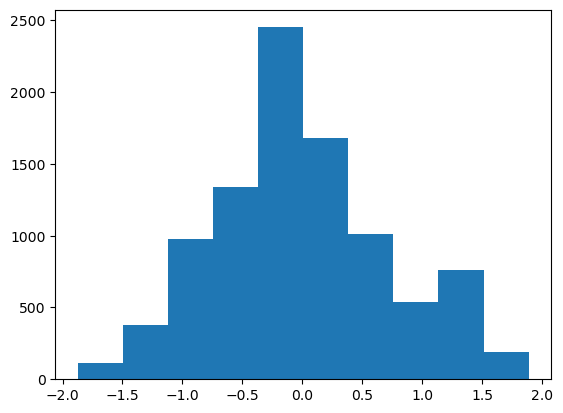

In [11]:
plt.hist(np.reshape(y, (-1,)), bins = 10)

(array([7.90000000e+01, 1.34200000e+03, 2.48150000e+04, 5.09528000e+05,
        2.63807570e+07, 2.62590575e+08, 1.20010120e+07, 5.66355000e+05,
        3.33150000e+04, 1.28900000e+03]),
 array([-10.12218285,  -8.2501545 ,  -6.37812519,  -4.50609684,
         -2.63406801,  -0.76203918,   1.10998952,   2.98201823,
          4.85404682,   6.72607565,   8.59810448]),
 <BarContainer object of 10 artists>)

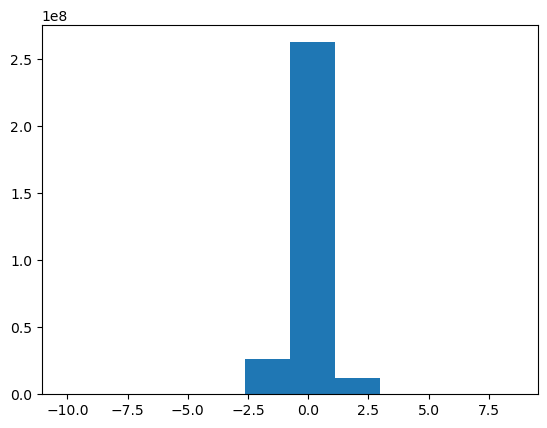

In [12]:
plt.hist(np.reshape(X_full, (-1,)), bins = 10)

Text(0.5, 1.0, 'Theta anomaly 2017_07_01')

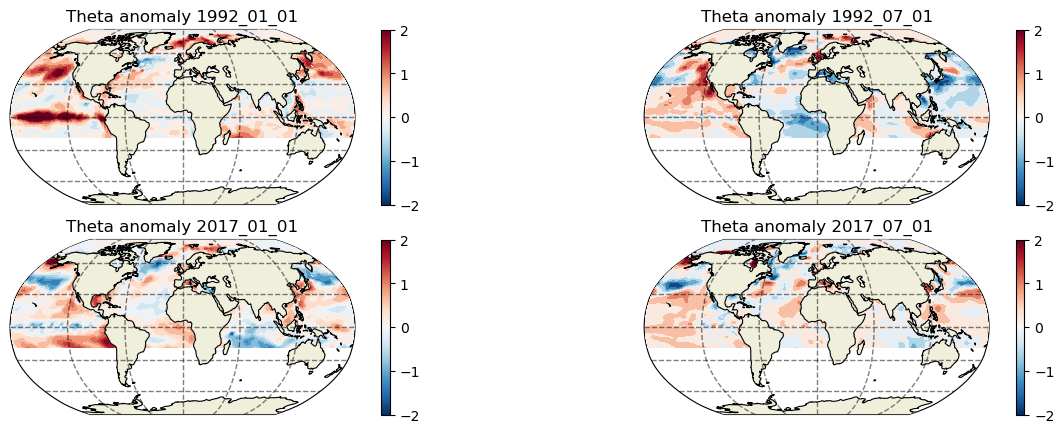

In [13]:
plt.figure(figsize=(15,5))

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'],
                              theta_anomaly[0],
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', cmin = -2, cmax = 2,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [2,2,1]);
P[1].set_title("Theta anomaly 1992_01_01")

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'],
                              theta_anomaly[182],
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', cmin = -2, cmax = 2,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [2,2,2]);
P[1].set_title("Theta anomaly 1992_07_01")

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'],
                              theta_anomaly[9132],
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', cmin = -2, cmax = 2,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [2,2,3]);
P[1].set_title("Theta anomaly 2017_01_01")

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'],
                              theta_anomaly[9313],
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', cmin = -2, cmax = 2,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [2,2,4]);
P[1].set_title("Theta anomaly 2017_07_01")

## Correlation maps

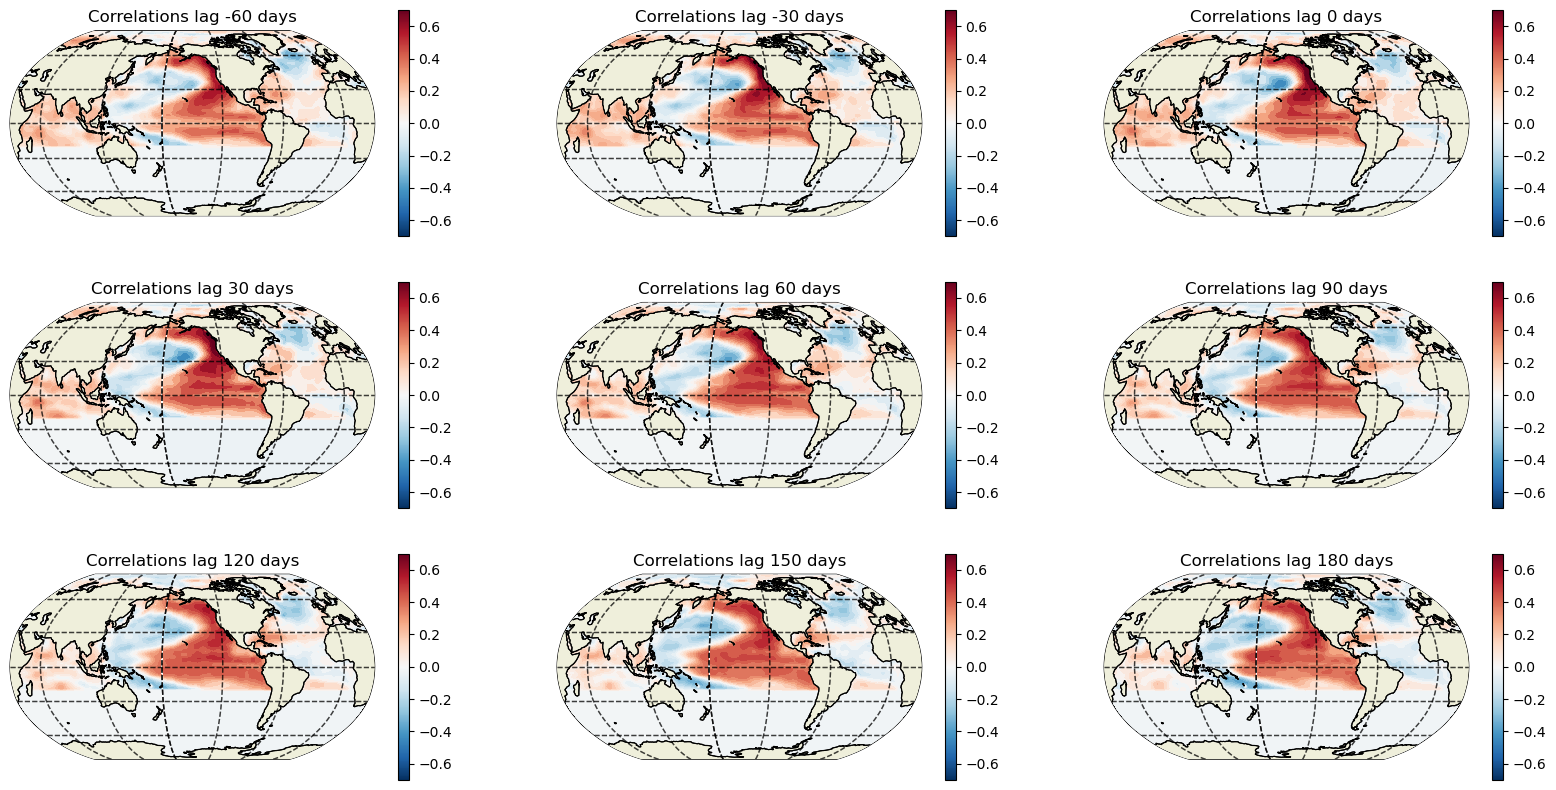

In [14]:
lagStepsList = [-60,-30,0,30,60,90,120,150,180]

subplot_idx = 1
plt.rcParams["figure.figsize"] = (20,10)

for lagSteps in lagStepsList:
    
    corr = np.zeros((13, 90, 90))
    
    if lagSteps > 0:
        corr[wetpoints[0], wetpoints[1], wetpoints[2]] = np.copy(correlation(X[:-lagSteps],y[lagSteps:]))
    elif lagSteps == 0:
        corr[wetpoints[0], wetpoints[1], wetpoints[2]] = np.copy(correlation(X,y))
    else:
        corr[wetpoints[0], wetpoints[1], wetpoints[2]] = np.copy(correlation(X[-lagSteps:],y[:lagSteps]))

    P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], corr,
                                  plot_type = 'contourf',
                                  show_colorbar=True, cmap='RdBu_r', 
                                  cmin = -0.7, cmax = 0.7, user_lon_0 = -150,
                                  dx=2, dy=2, projection_type = 'robin',
                                  less_output = True, subplot_grid = [3,3,subplot_idx]);
    P[1].set_title(f"Correlations lag {lagSteps} days")
    
    subplot_idx += 1

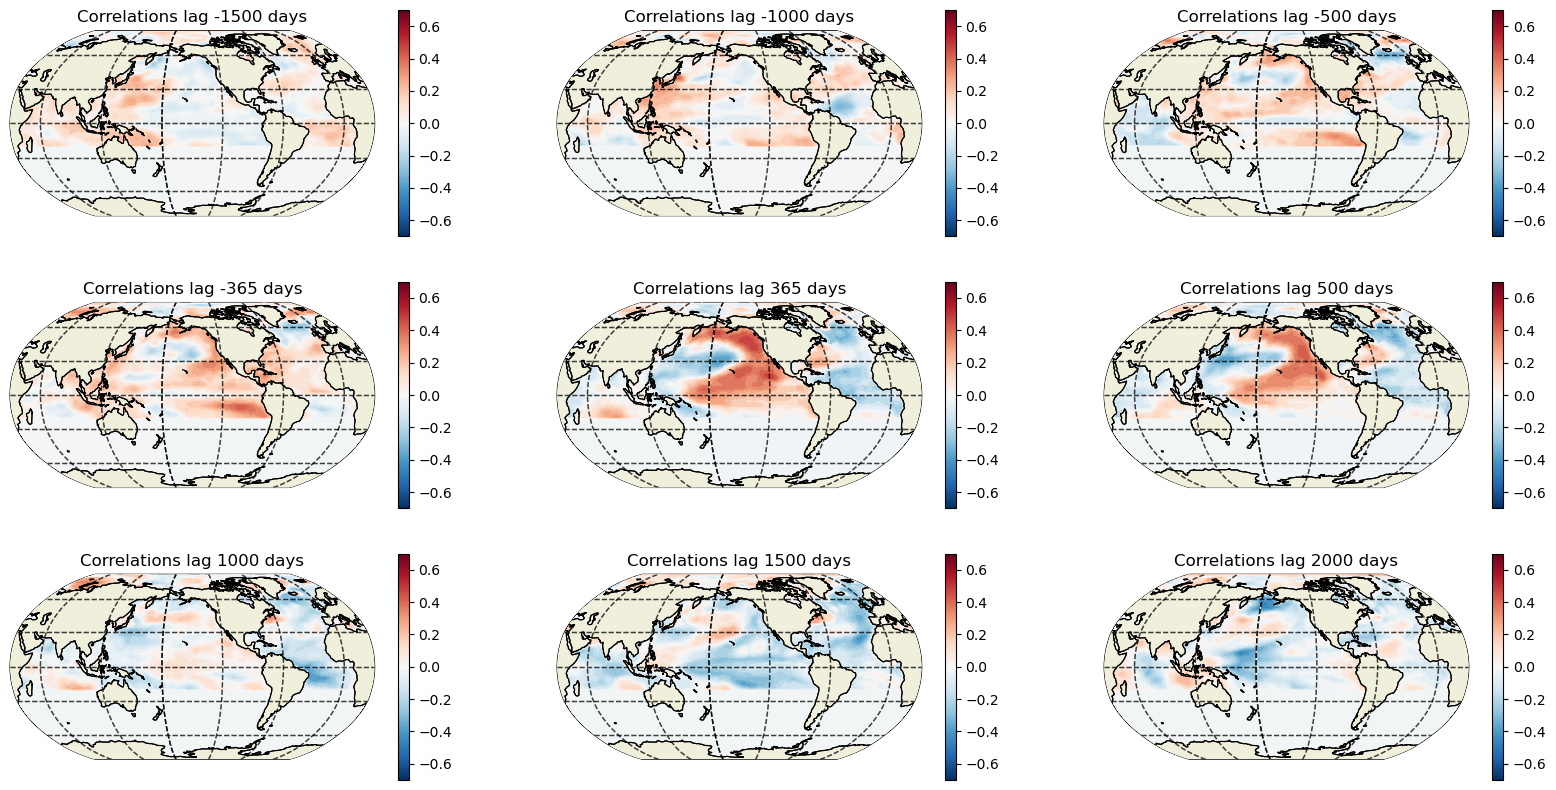

In [15]:
lagStepsList = [-1500,-1000,-500,-365,365,500,1000,1500,2000]

subplot_idx = 1
plt.rcParams["figure.figsize"] = (20,10)

for lagSteps in lagStepsList:
    
    corr = np.zeros((13, 90, 90))
    
    if lagSteps > 0:
        corr[wetpoints[0], wetpoints[1], wetpoints[2]] = np.copy(correlation(X[:-lagSteps],y[lagSteps:]))
    elif lagSteps == 0:
        corr[wetpoints[0], wetpoints[1], wetpoints[2]] = np.copy(correlation(X,y))
    else:
        corr[wetpoints[0], wetpoints[1], wetpoints[2]] = np.copy(correlation(X[-lagSteps:],y[:lagSteps]))

    P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], corr,
                                  plot_type = 'contourf',
                                  show_colorbar=True, cmap='RdBu_r', 
                                  cmin = -0.7, cmax = 0.7, user_lon_0 = -150,
                                  dx=2, dy=2, projection_type = 'robin',
                                  less_output = True, subplot_grid = [3,3,subplot_idx]);
    P[1].set_title(f"Correlations lag {lagSteps} days")
    
    subplot_idx += 1